<a href="https://colab.research.google.com/github/vanderbilt-ml/51-boyce-mlproj-NIDS/blob/main/NIDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Network Intrusion Detection System Classifier

###Background
Network Intrusion Detections Systems (NIDS) have been used in network defense for quite some time. It is of great importance, however, to keep NIDS systems updated to identify new and evolving attack types. Researchers at the University of Queensland, Australia have produced consolidated datasets to include attacks against IoT devices and data comprising attacks against multiple test networks. Of particular interest here as well is that the data is, essentially, brand new. 

###Description
The work in this project will focus on using the provided data to create a Machine Learning model that can be used to create a NIDS in my home lab. This is something I have wanted to do for quite some time. I do not have any IoT devices running in the lab at the moment but may in the future and will aply the IoT data here as well.

###Metric
For now, the goal will be to classify traffic reflected in the dataset - bot, recon, worm, etc - with a score of 60% to allow for human intervention/triage. At the moment, I'm not too worried about DoS as I do not think anyone is DoS'ing me.

###Sources
Per the request of the researchers in using the data for academic purposes, the following papers are cited:

Sarhan, M., Layeghy, S. & Portmann, M. Towards a Standard Feature Set for Network Intrusion Detection System Datasets. Mobile Netw Appl (2021). https://doi.org/10.1007/s11036-021-01843-0

M. Sarhan, S. Layeghy, and M. Portmann, An explainable machine learning-based network intrusion detection system for enabling generalisability in securing iot networks, 2021. arXiv:2104.07183 [cs.CR] https://arxiv.org/abs/2104.07183

Sarhan M., Layeghy S., Moustafa N., Portmann M. (2021) NetFlow Datasets for Machine Learning-Based Network Intrusion Detection Systems. In: Big Data Technologies and Applications. BDTA 2020, WiCON 2020. Springer, Cham. https://doi.org/10.1007/978-3-030-72802-1_9

##Libraries:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler, MinMaxScaler


##Load data

In [5]:
transactions = pd.read_csv('NF-UQ-NIDS-v2_half.csv', nrows=2000)


##Explore Data

In [8]:
#overall info
display(transactions.info())
#transactions.describe()
#transactions.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IPV4_SRC_ADDR                2000 non-null   object 
 1   L4_SRC_PORT                  2000 non-null   int64  
 2   IPV4_DST_ADDR                2000 non-null   object 
 3   L4_DST_PORT                  2000 non-null   int64  
 4   PROTOCOL                     2000 non-null   int64  
 5   L7_PROTO                     2000 non-null   float64
 6   IN_BYTES                     2000 non-null   int64  
 7   IN_PKTS                      2000 non-null   int64  
 8   OUT_BYTES                    2000 non-null   int64  
 9   OUT_PKTS                     2000 non-null   int64  
 10  TCP_FLAGS                    2000 non-null   int64  
 11  CLIENT_TCP_FLAGS             2000 non-null   int64  
 12  SERVER_TCP_FLAGS             2000 non-null   int64  
 13  FLOW_DURATION_MILL

None

In [ ]:
#source IP info 
display(transactions['IPV4_SRC_ADDR'].nunique())
display(transactions['IPV4_SRC_ADDR'].value_counts().idxmax())
#top_five_src = transactions['IPV4_SRC_ADDR'].value_counts()[:5].index.tolist()
#display(top_five_src)
display("**************************************************************")
#dest IP info
display(transactions['IPV4_DST_ADDR'].nunique())
display(transactions['IPV4_DST_ADDR'].value_counts().idxmax())
#top_five_dst = transactions['IPV4_DST_ADDR'].value_counts()[:5].index.tolist()
#display(top_five_dst)
display("**************************************************************")
#average packets inbound per session
display(transactions["IN_PKTS"].mean())
display("**************************************************************")
#average packets outbound per session
display(transactions["OUT_PKTS"].mean())
display("**************************************************************")
#Unknown data
display(transactions['PROTOCOL'].value_counts())
display(transactions['L7_PROTO'].value_counts())

402

'192.168.100.148'

'**************************************************************'

276

'192.168.100.3'

'**************************************************************'

7.4145

'**************************************************************'

4.113

'**************************************************************'

6     1230
17     767
1        2
2        1
Name: PROTOCOL, dtype: int64

0.000      665
7.000      631
188.000    473
91.000      44
5.126       40
1.000       18
91.178      13
7.178       11
41.000      11
91.126      10
5.178       10
131.700      9
92.000       9
77.000       7
5.119        5
5.240        4
4.000        4
5.239        3
91.239       3
91.140       2
7.126        2
166.000      2
91.120       2
91.212       2
91.119       1
51.000       1
5.233        1
91.240       1
28.000       1
91.290       1
2.000        1
91.233       1
29.000       1
5.700        1
5.000        1
10.000       1
5.169        1
226.000      1
131.000      1
5.120        1
150.000      1
5.215        1
88.000       1
5.212        1
Name: L7_PROTO, dtype: int64

([<matplotlib.patches.Wedge at 0x7ff04a81d7d0>,
 [Text(0.8723622171446687, 0.6700628045925532, '192.168.100.148'),
  Text(-0.4105293228121579, 1.0205222560588236, '192.168.100.147'),
  Text(-1.0994914161546159, 0.033445863754989494, '192.168.100.149'),
  Text(-0.6546554873688508, -0.883983140595935, '192.168.100.150'),
  Text(0.09124219293333284, -1.0962093149707846, '192.168.1.31'),
  Text(0.5845348205949307, -0.9318363823719551, '192.168.1.32'),
  Text(0.8983119082306691, -0.6348509396157291, '192.168.1.30'),
  Text(1.038180581316866, -0.3635671610260943, '192.168.1.35'),
  Text(1.0812704142442073, -0.2021244450336484, '192.168.1.39'),
  Text(1.0979661313836486, -0.0668608580144201, '192.168.1.34')])

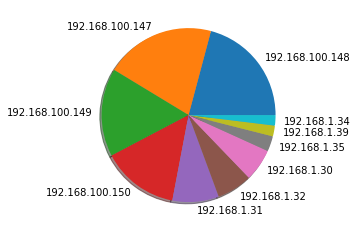

In [ ]:
#visualize top 10 src IPs
#running on top 10 for display purposes
src_ips = transactions['IPV4_SRC_ADDR'].value_counts()[:10]
plt.pie(src_ips, labels=src_ips.index, shadow = True)


PROTOCOL
1        2
2        1
6     1230
17     767
dtype: int64

TCP_FLAGS
0      770
2      543
16      11
17       3
18      23
19      34
20       4
22     202
23       9
24      14
25       2
26       1
27     135
28       1
30      47
31      27
211      3
214      3
219     63
222     48
223     57
dtype: int64

<BarContainer object of 4 artists>

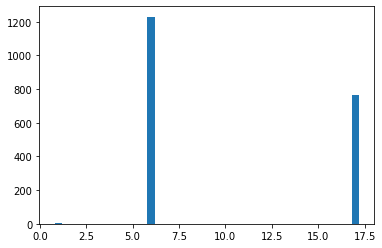

In [6]:
#visualize PROTOCOL and TCP FLAGS 
proto = transactions['PROTOCOL'].value_counts()
#plt.pie(proto, labels=proto.index, shadow = True)

src_port = transactions['L4_SRC_PORT'].value_counts()
#plt.pie(src_port, labels=src_port.index, shadow = True)
#plt.scatter(x=transactions['L4_SRC_PORT'], y=transactions['PROTOCOL'])
tcp_flags = transactions['TCP_FLAGS'].value_counts()

#plt.scatter(x=transactions['TCP_FLAGS'], y=transactions['PROTOCOL'])
#tcp flag as 0 means not TCP
#what this shows is that when TCP flags are 0, the corresponding protocol is not TCP(UDP)

protos = transactions.groupby(['PROTOCOL']).size()
display(protos)
tcp_fls = transactions.groupby(['TCP_FLAGS']).size()
display(tcp_fls)

plt.bar(proto.index, proto.values, width=0.8)

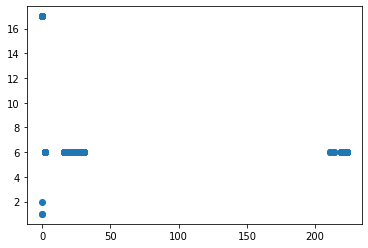

In [ ]:
plt.scatter(x=transactions['TCP_FLAGS'], y=transactions['PROTOCOL'])
#tcp flag as 0 means not TCP
#what this shows is that when TCP flags are 0, the corresponding protocol is not TCP(UDP)
#the 6 on the y axis has flags set the vast majority of the time

In [ ]:
#visualize 